# This notebook shows the built-in classification functionality. Classification here means marking points/tracks True/False if they meet certain conditions.

# This helps build complex conditional logic and allows for faster filtering/querying later on for tracks of interest.

___

In [1]:
import trackio as tio
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np

___
## Again, let's use the AIS data we've already been working with.

In [2]:
#create the Dataset
ds = tio.read(data_path='example00')

## Classifying in Polygon

This function will classify points along polygons True if they are on/within a polygon, and False elsewhere.

In [3]:
#define a polygon
polygon = gp.read_file('files/lateral_clip.gpkg').geometry.iloc[0]

#classify the tracks
ds = ds.classify_in_polygon(polygon, 
                            ncores=4,
                            code=16)

Classifying tracks inside polygon: 100%|██████████| 163/163 [00:02<00:00, 70.36it/s]


## Notice how if you refresh the metadata now, you can see the in-polygon information has been added to the various metadata tables.

In [4]:
#refresh meta
ds = ds.refresh_meta(ncores=4)

ds

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 66.36it/s]  


New meta/databases saved to c:\code\trackio\notebooks\example00


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Acceleration', 'Code16', 'Coursing', 'Distance Travelled', 'Radius of Curvature', 'Raster', 'Sinuosity', 'Speed', 'Time', 'Turning Rate', 'X', 'Y']
Metadata:
    X: metre
    Y: metre
    CRS: EPSG:3857
    Coursing: degrees
    Turning Rate: degrees/sec
    Speed: metre/second
    Acceleration: metre/second/second
    Distance Travelled: metre
    Radius of Curvature: metre
    Sinuosity: non-dimensional
    Code16: Inside Polygon
Data Path:
    c:\code\trackio\notebooks\example00

In [5]:
ds.agents.head(5).filter(like='Code')

,Code16
Agent ID,
Vessel_367634360,False
Vessel_367661340,True
Vessel_367000190,False
Vessel_338093826,False
Vessel_367014210,False


In [6]:
ds.tracks.head(5).filter(like='Code')

,Code16
Track ID,
Vessel_367634360_T0,False
Vessel_367661340_T0,True
Vessel_367000190_T0,False
Vessel_338093826_T0,False
Vessel_367014210_T0,False


## Now you know every track that had points on/in this polygon. Let's plot one.

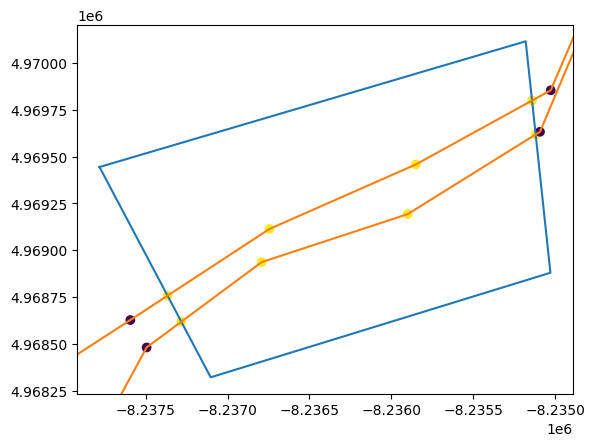

In [7]:
#get the track
track = ds.get_track(ds.tracks.loc[ds.tracks['Code16']].index[0])

#plot track and polygon
plt.plot(*polygon.exterior.xy)
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())
plt.plot(track['X'], track['Y'])
plt.scatter(track['X'], track['Y'], c=track['Code16'])


___
## You can also do the same thing for multiple polygons at once.

Here, the input must be a `geopandas.GeoDataFrame` that contains a `Code` and `geometry` column. The geometry must all be `shapely.geometry.Polygon` objects.

In [8]:
#define polygons
polygons = gp.read_file('files/multiple_polygons.gpkg')

polygons

,Code,geometry
0,100,"POLYGON ((-8241168.894 4953532.036, -8241248.3..."
1,101,"POLYGON ((-8248897.263 4958674.863, -8248969.7..."
2,102,"POLYGON ((-8243274.062 4960115.985, -8243366.5..."
3,103,"POLYGON ((-8236916.171 4962743.913, -8237028.8..."
4,104,"POLYGON ((-8233327.495 4968423.629, -8233469.6..."
5,105,"POLYGON ((-8239261.526 4969553.921, -8239355.6..."
6,106,"POLYGON ((-8240278.789 4966445.619, -8240324.3..."
7,107,"POLYGON ((-8241691.653 4961076.733, -8241626.8..."


## If you pass `to_codes=True`, a `Code` column will be created for each polygon, similar to the previous single polygon function.

## If you pass `to_codes=False` a single column named `name` will be created which contains a series of code values depending on which polygon each point was in along a track.

In [9]:
#classify points inside the polygons
ds = ds.classify_in_polygons(polygons, 
                             ncores=4,
                             to_codes=True)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 56.39it/s]


New meta/databases saved to c:\code\trackio\notebooks\example00


In [10]:
#get all the tracks that went within Polygon 103
gdf = ds.to_gdf(tracks=ds.tracks.loc[ds.tracks['Code103']].index, ncores=4)
df = ds.to_df(tracks=ds.tracks.loc[ds.tracks['Code103']].index, ncores=4)

Converting tracks to DataFrame: 100%|██████████| 51/51 [00:03<00:00, 16.29it/s] 


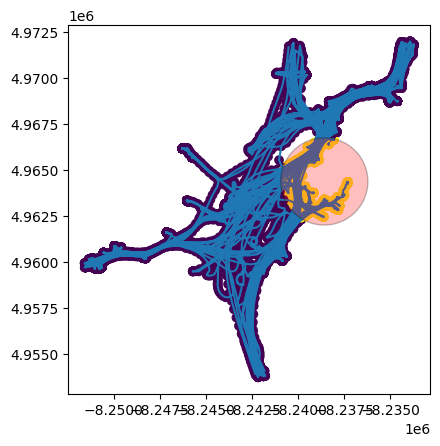

In [11]:
#plot tracks and polygon
polygons.iloc[[3]].plot(edgecolor='k', alpha=0.25, color='r', zorder=10)
gdf.plot(ax=plt.gca())
plt.scatter(df['X'], df['Y'], c=df['Code103'])

Converting tracks to DataFrame: 100%|██████████| 163/163 [00:03<00:00, 54.19it/s]


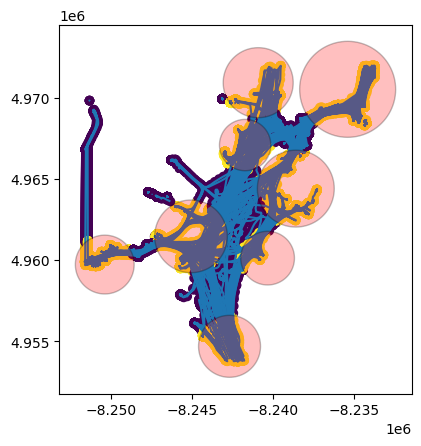

In [12]:
#plot all points in polygons
gdf = ds.to_gdf(ncores=4)
df = ds.to_df(ncores=4)
#plot tracks and polygon
polygons.plot(edgecolor='k', alpha=0.25, color='r', zorder=10)
gdf.plot(ax=plt.gca())
plt.scatter(df['X'], df['Y'], c=df.filter(like='Code').any(axis=1))

## If you choose to create a single column, you can then get a time series of movements across different polygons. Note here that if a point is outside of a polygon, the value will be zero at that point.

In [13]:
#classify points inside the polygons
ds = ds.classify_in_polygons(polygons, 
                             ncores=4,
                             name='Which Polygon?',
                             to_codes=False)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:03<00:00, 53.81it/s]  


New meta/databases saved to c:\code\trackio\notebooks\example00


<Axes: >

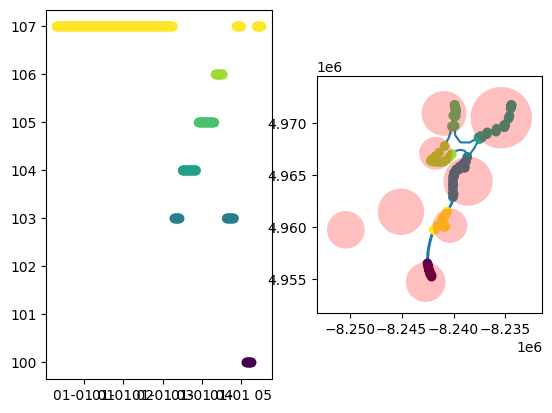

In [14]:
#pick a track that has alot of polygon crossings
idx = ds.tracks.filter(like='Code').sum(axis=1).argmax()

#get track
track = ds.get_track(ds.tracks.index[idx])

#plot timeseries of code and track/polygons
fig, ax = plt.subplots(1,2)
ax[0].scatter(track['Time'], track['Which Polygon?'].replace(0, np.nan), c=track['Which Polygon?'], vmin=100, vmax=107)
ax[1].plot(track['X'], track['Y'])
ax[1].scatter(track['X'], track['Y'], c=track['Which Polygon?'].replace(0, np.nan), vmin=100, vmax=107, zorder=2)
polygons.plot(ax=ax[1], zorder=10, color='r', alpha=0.25)

##

speed
speed_in_polygon
classify turns
classify trip
touching
Stops
custom